# Project Description

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
You have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis course). For this classification task, you need to develop a model that will pick the right plan. Since you’ve already performed the data preprocessing step, you can move straight to creating the model.
Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.

## Importing Packages

In [3]:
#import packages
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
!pip install optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_optimization_history
!pip install --user yellowbrick
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires statsmodels<=0.12.1, but you have statsmodels 0.13.0 which is incompatible.


### Details

| Package          | Description                                                          |
|:-----------------|:---------------------------------------------------------------------|
| pandas           | For data preprocessing and basic descriptive statistics.             |                                
| warnings         | For ignoring warnings after finishing the project for readability.   |
| time             | To calculate run times for sections of code.                         |
| sklearn          | For running machine learning models.                                 |
| Optuna           | For hyperparameter optimization.                                     |
| yellowbrick      | For machine learning visualizations.                                 |



## Importing Data

In [5]:
#import data
try:
    mobile_df = pd.read_csv('/Users/bnoah/data/users_behavior.csv')
except:
    mobile_df = pd.read_csv('/datasets/users_behavior.csv')

### Conclusions

The data has already been preprocessed so we do not need to do any further processing.

## Splitting Data

In [6]:
mobile_df_train, mobile_df_test_valid = train_test_split(mobile_df, test_size=0.30, random_state=13)
mobile_df_test, mobile_df_valid = train_test_split(mobile_df_test_valid, test_size=0.50, random_state=13)

### Conclusions

I split the dataset using the commonly used ratio of 70/15/15. I did not split with stratified sampling, but that is something that could be considered when splitting the data. 

## Model Testing

### Splitting Features and Target

In [7]:
#splitting for training data
X_train = mobile_df_train.drop('is_ultra', axis=1)
y_train = mobile_df_train['is_ultra']
#splitting for validating data
X_val = mobile_df_valid.drop('is_ultra', axis=1)
y_val = mobile_df_valid['is_ultra']
#splitting for test data
X_test = mobile_df_test.drop('is_ultra', axis=1)
y_test = mobile_df_test['is_ultra']

### Decision Tree Classification

In [17]:
def dt_objective(trial):
    #defining ranges for random forest optimization
    criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 50,1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    min_samples_split = trial.suggest_uniform('min_samples_split', 0, 1)
    #creating model
    model = DecisionTreeClassifier(criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 min_samples_split = min_samples_split)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    #getting accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

start_time = time.time()
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(dt_objective, n_trials=1000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 13.121801376342773 seconds ---


In [18]:
print('Highest Accuracy',study_dt.best_value)

plot_optimization_history(study_dt)

Highest Accuracy 0.8095238095238095


#### Conclusion

For this section, I looked at a Decision Tree Classification Model. I used Optuna to find the optimal hyperparameters based on accuracy. The 4 hyperparameters I looked at were:

- **criterion**: The function to measure the quality of a split.
- **max_depth**: The maximum depth of the tree.
- **max_features**: The number of features to consider when looking for the best split
- **min_samples_split**: The minimum number of samples required to split an internal node

<cite>[Source][1]</cite> 

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

I then optimized the model based on accuracy and, after 1000 trials, the highest accuracy of a Decision Tree Classification Model was ~**81.0%**.

### Random Forest Classification

In [10]:
def rf_objective(trial):
    #defining ranges for random forest optimization
    criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 50,1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    min_samples_split = trial.suggest_uniform('min_samples_split', 0, 1)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000,100)
    #creating model
    model = RandomForestClassifier(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 min_samples_split = min_samples_split,n_estimators = n_estimators)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    #getting accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

start_time = time.time()
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_objective, n_trials=100)
print("--- %s seconds ---" % (time.time() - start_time))

--- 89.06008410453796 seconds ---


In [11]:
print('Highest Accuracy',study_rf.best_value)

plot_optimization_history(study_rf)

Highest Accuracy 0.8074534161490683


#### Conclusions

For this section, I looked at a Random Forest Classification Model. I used Optuna to find the optimal hyperparameters based on accuracy. The 6 hyperparameters I looked at were:

- **criterion**: The function to measure the quality of a split.
- **bootstrap**: Whether bootstrap samples are used when building trees.
- **max_depth**: The maximum depth of the tree.
- **max_features**: The number of features to consider when looking for the best split
- **min_samples_split**: The minimum number of samples required to split an internal node
- **n_estimators**: The number of trees in the forest.

<cite>[Source][2]</cite> 

[2]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

I then optimized the model based on accuracy and, after 100 trials, the highest accuracy of a Random Forest Classification Model was ~**81.0%**.

### Logistic Regression Model

In [20]:
def lr_objective(trial):
    #defining ranges for random forest optimization
    penalty = trial.suggest_categorical('penalty',['none','l2'])
    C = trial.suggest_categorical('C',[0.001,0.01,0.1,1,10,100,1000])
    #creating model
    model = LogisticRegression(penalty=penalty, C=C)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    #getting accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy
start_time = time.time()
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(lr_objective, n_trials=1000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.817525386810303 seconds ---


In [21]:
print('Highest Accuracy',study_lr.best_value)

plot_optimization_history(study_lr)

Highest Accuracy 0.7163561076604554


#### Conclusions

For this section, I looked at a Logistic Regression Model. I used Optuna to find the optimal hyperparameters based on accuracy. The 2 hyperparameters I looked at were:

- **penalty**: Specify the norm of the penalty
- **C**: Inverse of regularization strength

<cite>[Source][3]</cite> 

[3]: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

I then optimized the model based on accuracy and, after 1000 trials, the highest accuracy of a Logistic Regression Model was **72.0%**.

### Visualizations

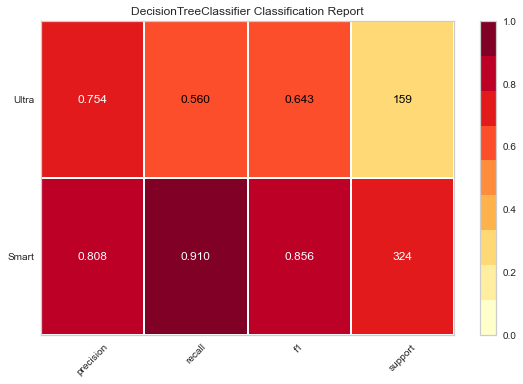

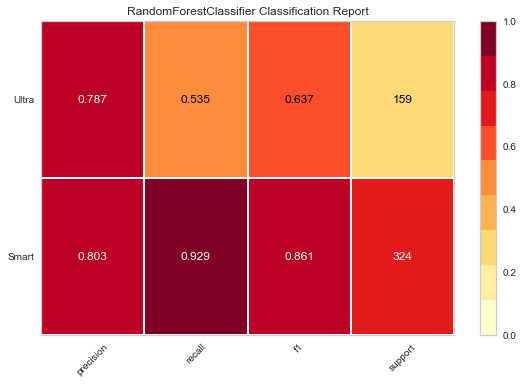

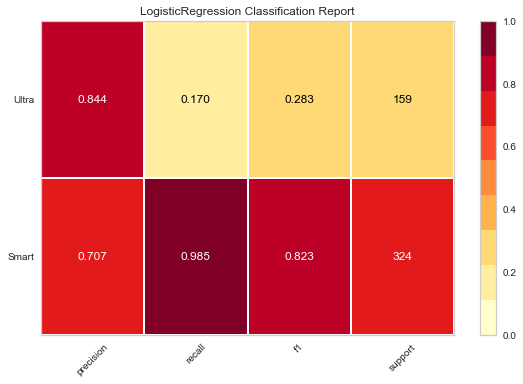

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [23]:
#creating a decison tree classifier model with optimal hyperparameters
#adding class labels
classes = ['Smart','Ultra']
#looking at the decision tree classifier model
model_dt = DecisionTreeClassifier(random_state=13).set_params(**study_dt.best_params)
visualizer = ClassificationReport(model_dt,support=True,classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

#looking at the random forest classifier model
model_rf = RandomForestClassifier(random_state=13).set_params(**study_rf.best_params)
visualizer = ClassificationReport(model_rf,support=True,classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show() 

#looking at the logistic regression model
model_lr = LogisticRegression(random_state=13).set_params(**study_lr.best_params)
visualizer = ClassificationReport(model_lr,support=True,classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show() 

#### Conclusions

Variable Definitions
- **Precision**: the ratio of true positives to the sum of true and false positives
- **Recall**: the ratio of true positives to the sum of true positives and false negatives
- **F1**: a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0
- **Support**: the number of actual occurrences of the class in the specified dataset


As you can see from the above graphs, the differences in performance between the random forest and decision tree classification models were insignificant. Yet, I was able to run a 1,000 trial Optuna optimization study for the decision tree classification model in 17 seconds, while it took 185 seconds to run a 100 trial Optuna optimization study for the random forest classification model.

Next, compared to the Logistic Regression, both classification models had significantly higher accuracies. Looking at the classification reports, this seems to be due to the logistic regression's incredibly low recall for those who select the Ultra plan. This tells us that the logistic regression placed way too many people in the Smart plan. 


Overall, I think the choice comes down to the random forest and the decision tree classification models. In this instance, since the difference in accuracy is incredibly small, I am choosing to use the decision tree classification model due to the speed of the model. 

## Checking The Model With Test Data

In [24]:
y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print('Accuracy of Decison Tree Model:', accuracy_dt)

y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print('Accuracy of Random Forest Model:', accuracy_rf)

y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print('Accuracy of Logisitc Regression Model:', accuracy_lr)




Accuracy of Decison Tree Model: 0.8174273858921162
Accuracy of Random Forest Model: 0.8257261410788381
Accuracy of Logisitc Regression Model: 0.7427385892116183


### Conclusions

When applying the models to the testing data, the Random Forest Model outperformed the Decision Tree Model by **1.2%** and outperformed the Logistic Regression by **8.7%**. 

While these results show the Random Forest Model having the highest accuracy, I believe the Decision Tree Model could still be considered optimal due to the run time. 

## Overall Conclusions

In this project, I looked at three different models and tried to figure out which one best predicted the plan choice of the 3214 individuals who have switched over to the new phone plans. 

1. I started by splitting the data using the commonly used 70/30/30 rule where 70 percent of your data is used for training, 30 percent is used for validating, and 30 percent is used for testing. 
2. Then used Optuna to find the optimal values for the hyperparameters for each model. 
3. Lastly, I found the accuracy of each of the three models using the test data. 

My results show that Megaline should focus on Decision Tree and Random Forest models to predict the new plan choice of legacy plan holders as they both had accuracies of over 80 percent.

The only other factor to consider is that it is possible that people who already switched over to new plans are very different than people that are still on their legacy plans. If this were the case, then our predictions could be far off due to these differences that are not accounted for in our model. 